In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "tensorflow"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

TensorFlow是一个用于数值计算的强大开源软件，非常适合大型机器学习。背后原理很简单：首先在Python中定义一个用来计算的图，然后TensorFlow就会使用这个图，并通过优化的C++代码来执行计算。

# 安装

In [1]:
# !pip install --upgrade tensorflow==1.13

# 创建一个计算图并在会话中运行

In [2]:
import tensorflow as tf

print(tf.__version__)

1.13.2


In [5]:
reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

Instructions for updating:
Colocations handled automatically by placer.


定义一个计算图非常简单，如上显示，定义了$f=3\times 3\times 4+4+2$，然而，这段代码没有任何计算，尽管看起来有点像，实际上仅仅创建了一个计算图而已,连变量都未初始化。

In [6]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [7]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [8]:
sess.close()

更好的方式

In [9]:
with tf.Session() as sess:
    x.initializer.run() # tf.get_default_session().run(x.initializer)
    y.initializer.run()
    result = f.eval() #等于tf.get_default_session().run(f)

In [10]:
result

42

更好的方式

In [11]:
init = tf.global_variables_initializer() # 创建初始化节点

with tf.Session() as sess:
    init.run()
    result = f.eval()
result

42

在Jupyter或者Python shell中

In [12]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


一个TensorFlow程序中通常可以分为两部分：第一部分用来构建一个计算图(称为构建阶段),第二部分用来执行这个图(称为执行阶段)

# 管理图

我们创建的所有节点都会自动添加到默认图上：

In [13]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

如果我们想要管理多个互不依赖的图

In [14]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

在Jupyter中，做实验时，我们经常会多次执行同一条命令，这样会在同一个图上添加很多重复节点。一种是重启jupyter，更方便的是通过`tf.reset_default_graph()`来重置默认图

In [15]:
x2.graph is tf.get_default_graph()

False

# 节点值的生命周期

In [16]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


在对某个节点求值时，TensorFlow会自动检测该节点依赖的节点，并对这些节点求值。在每次执行间，节点的值会丢失，但是变量的值不会，因为变量值由session会话维护。变量的生命周期为session的开始到结束。

In [17]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# TensorFlow中的线性回归

TensorFlow中的操作(op)可以接收任意数量的输入，也可以产生任意数量的输出，输入和输出都是多维数组，也叫做张量(Tensor,这也是TensorFlow名字的来源)

标准方程法求解

In [18]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

In [19]:
housing_data_plus_bias.shape

(20640, 9)

$$
\hat{\theta}=(X^T\cdot X)^{-1}\cdot X^T \cdot y
$$

In [20]:
reset_graph()
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [23]:
theta_value

array([[-3.6845909e+01],
       [ 4.3667579e-01],
       [ 9.4581824e-03],
       [-1.0708507e-01],
       [ 6.4334780e-01],
       [-3.9223705e-06],
       [-3.7883162e-03],
       [-4.2040566e-01],
       [-4.3347809e-01]], dtype=float32)

对比numpy

In [24]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [26]:
print(np.sum((theta_value-theta_numpy)**2))

0.009223035762991254


In [27]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))
theta_lr=np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T]
print(theta_lr)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [28]:
print(np.sum((theta_value-theta_lr)**2))

0.009223035628102177


In [29]:
print(np.sum((theta_numpy-theta_lr)**2))

4.9349613609184855e-19


# 实现梯度下降

梯度下降需要先标准化，虽然TF中也可以，但首先在sklearn中实现标准化

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [31]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


## 手工计算梯度

$$\frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T\cdot x^{i}-y^{i})x_j^{i}$$

* `random_uniform`会创建一个节点，这个节点会产生一个张量，函数会根据输入维度来生成随机值填充这个张量。
* `assign`会创建一个为变量赋值的节点。

In [39]:
from time import time

In [41]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# x*theta
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    time_s=time()
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    print("cost time:{}".format(time()-time_s))
    best_theta_h = theta.eval()

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.5555718
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.5396291
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
cost time:0.5262846946716309


In [42]:
best_theta_h

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614529 ],
       [-0.6375279 ]], dtype=float32)

In [43]:
print(np.sum((theta_value-best_theta_h)**2))

1514.7952


## 使用自动微分

TensorFlow最强大的点之一在于实现了自动求偏导。

In [44]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [45]:
gradients = tf.gradients(mse, [theta])[0] # ==gradients = 2/m * tf.matmul(tf.transpose(X), error)

In [46]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    time_s=time()
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    print("cost time:{}".format(time()-time_s))
    best_theta_a = theta.eval()

print("Best theta:")
print(best_theta_a)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450037
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.5555718
Epoch 400 MSE = 0.54881126
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
cost time:0.4470841884613037
Best theta:
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.3477088 ]
 [ 0.36178365]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


In [47]:
print(np.sum((theta_value-best_theta_a)**2))

1514.7952


## 使用优化器

TensorFlow会帮我们计算梯度，不过还提供了更容易的办法，这就是优化器，可以实现自动求梯度和下降的过程

In [48]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [49]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse) # == gradients=。。。。 and  training_op=。。。。

In [50]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.5555718
Epoch 400 MSE = 0.54881126
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.3477088 ]
 [ 0.36178365]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


In [51]:
print(np.sum((theta_value-best_theta)**2))

1514.7952


### 使用动量梯度下降

In [52]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [53]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [54]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [55]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta_m = theta.eval()

print("Best theta:")
print(best_theta_m)

Best theta:
[[ 2.068558  ]
 [ 0.82962847]
 [ 0.11875335]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450249]
 [-0.03932662]
 [-0.8998645 ]
 [-0.8705207 ]]


In [56]:
print(np.sum((theta_value-best_theta_m)**2))

1515.0635


# 给训练算法提供数据

之前都是批量梯度下降运算，下面修改为小批量的梯度下降运算。

## 占位符

In [57]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3)) # 占位符
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

[[6. 7. 8.]]


In [58]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


### 小批量梯度下降优化

In [59]:
learning_rate = 0.01

In [60]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [61]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [62]:
n_epochs = 10 #总轮数

In [63]:
batch_size = 100 # 每轮取100个数据 m为数据个数，一轮取 n_batches次
n_batches = int(np.ceil(m / batch_size))

In [65]:
# 获取 batch_size个数据
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [66]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255152],
       [-0.31211877],
       [ 0.38510376],
       [ 0.00434168],
       [-0.0123295 ],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

In [67]:
print(np.sum((theta_value-best_theta)**2))

1515.0856


# 保存和恢复模型

训练好后，模型参数要保存到硬盘，这样就可以在任何时候使用这些参数。我们可以希望定期保存这些参数，以防止电脑崩溃的时候，可以在最近一个检查点恢复，而不需要从头再来。

在TensorFlow中，可以通过创造Saver节点，然后定期执行save并传入一个会话和检查文件的路径即可保存。

In [68]:
reset_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
error = y_pred - y                                                                    # not shown
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
training_op = optimizer.minimize(mse)                                                 # not shown

init = tf.global_variables_initializer()
# 创建节点
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
            #保存
            save_path = saver.save(sess, "./tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta_o = theta.eval()
    # 保存
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.5555718
Epoch 400 MSE = 0.54881126
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473


In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # not shown in the book

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


In [70]:
print(np.sum((best_theta_o-best_theta_restored)**2))

0.0


In [71]:
np.allclose(best_theta_o, best_theta_restored)

True

### 我们也可以只保存参数

In [72]:
saver = tf.train.Saver({"weights": theta})

By default the saver also saves the graph structure itself in a second file with the extension .meta. You can use the function tf.train.import_meta_graph() to restore the graph structure. This function loads the graph into the default graph and returns a Saver that can then be used to restore the graph state (i.e., the variable values):

默认的saver会保存模型网络结构，我们可以使用`tf.train.import_meta_graph`来加载模型网络结构，通过`tf.get_default_graph().get_tensor_by_name`获取张量

In [73]:
reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("./tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


In [74]:
np.allclose(best_theta_o, best_theta_restored)

True

# 用TensorBoard来可视化和训练曲线

In [75]:
## 被墙了
# from tensorflow_graph_in_jupyter import show_graph
# show_graph(tf.get_default_graph())

In [76]:
reset_graph()

from datetime import datetime
# 保存文件路径
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [77]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [78]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [79]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [80]:
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # not shown

In [81]:
file_writer.close()

In [82]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255152],
       [-0.31211877],
       [ 0.38510376],
       [ 0.00434168],
       [-0.0123295 ],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# 命名作用域

在处理诸如神经网络等复杂模型时，图很容易变得杂乱而庞大，为了避免这种情况，我们可以创建命名作用域来将相关的节点分组。

In [87]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [88]:
# 对损失计算归档
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [89]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [90]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255152]
 [-0.31211877]
 [ 0.38510376]
 [ 0.00434168]
 [-0.0123295 ]
 [-0.83376896]
 [-0.8030471 ]]


In [92]:
print(error.op.name,mse.op.name)

loss/sub loss/mse


In [93]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# 模块化

不采用模块化，代码会变得复杂 冗余 难以维护

In [94]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z2, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

In [95]:
file_writer = tf.summary.FileWriter("tf_logs/relu0", tf.get_default_graph())

好一点的方式

In [96]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [97]:
file_writer = tf.summary.FileWriter("tf_logs/relu1", tf.get_default_graph())

更好的方式

In [98]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    # not shown
        b = tf.Variable(0.0, name="bias")                             # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                      # not shown
        return tf.maximum(z, 0., name="max")                          # not shown

In [99]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("tf_logs/relu2", tf.get_default_graph())
file_writer.close()

# 共享变量

如果我们想要在图的不同组件中共享变量，最简单的方式是先创建，然后将其作为参数传递给需要它的函数

In [ ]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

另一种方法是把共享变量作为属性

In [ ]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

此外，TensorFlow也为此提供了一个选择，虽然理解起来较为困难，但是会频繁使用。该方法会先通过`get_variable()`创建一个共享变量，如果已经存在，就复用，通过`reuse=True`或者`scope.reuse_variables()`来复用。

In [101]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

如果已经创建，该代码会异常

In [102]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

复用的第一种方法

In [ ]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

复用的第二种方法

### 总结

In [103]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
# 创建共享变量
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [104]:
file_writer = tf.summary.FileWriter("tf_logs/relu6", tf.get_default_graph())
file_writer.close()

将relu集成到网络里面

In [105]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("tf_logs/relu8", tf.get_default_graph())
file_writer.close()

书上的方法

In [106]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [107]:
file_writer = tf.summary.FileWriter("tf_logs/relu9", tf.get_default_graph())
file_writer.close()

# 拓展

In [108]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


## 字符串

In [109]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


# 练习

## 12. tensorflow 做月亮数据

In [110]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

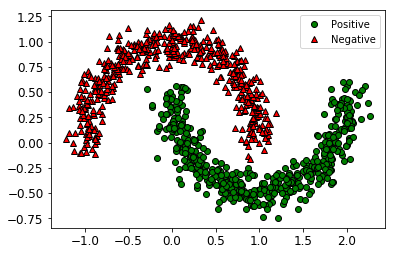

In [122]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive",markeredgecolor="black",markeredgewidth=1)
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative",markeredgecolor="black",markeredgewidth=1)
plt.legend()
plt.show()

In [123]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [124]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [125]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [126]:
y_moons_column_vector.shape

(1000, 1)

In [127]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [128]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [129]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [130]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]], dtype=int64)

In [131]:
reset_graph()
n_inputs = 2
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))
y_proba = tf.sigmoid(logits)
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

Instructions for updating:
Use tf.cast instead.


In [132]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [133]:
init = tf.global_variables_initializer()

In [134]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.79260236
Epoch: 100 	Loss: 0.3434635
Epoch: 200 	Loss: 0.30754042
Epoch: 300 	Loss: 0.29288897
Epoch: 400 	Loss: 0.28533575
Epoch: 500 	Loss: 0.2804781
Epoch: 600 	Loss: 0.27808294
Epoch: 700 	Loss: 0.27615443
Epoch: 800 	Loss: 0.27551997
Epoch: 900 	Loss: 0.27491236


In [135]:
y_proba_val[:5]

array([[0.54895616],
       [0.7072437 ],
       [0.51900256],
       [0.9911136 ],
       [0.5085905 ]], dtype=float32)

In [136]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [137]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [138]:
recall_score(y_test, y_pred)

0.8888888888888888

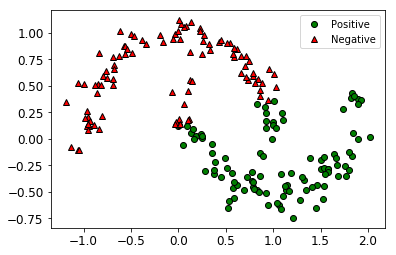

In [140]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive",markeredgecolor="black",markeredgewidth=1)
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative",markeredgecolor="black",markeredgewidth=1)
plt.legend()
plt.show()

In [141]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [142]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

In [143]:
reset_graph()
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [144]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [145]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [146]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.62998503
Epoch: 500 	Loss: 0.16122366
Epoch: 1000 	Loss: 0.119032115
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.083697945
Epoch: 2500 	Loss: 0.07437584
Epoch: 3000 	Loss: 0.067502156
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026794
Epoch: 4500 	Loss: 0.05456298
Epoch: 5000 	Loss: 0.051708292
Epoch: 5500 	Loss: 0.049237743
Epoch: 6000 	Loss: 0.04716729
Epoch: 6500 	Loss: 0.045376647
Epoch: 7000 	Loss: 0.04381875
Epoch: 7500 	Loss: 0.042374223
Epoch: 8000 	Loss: 0.041089166
Epoch: 8500 	Loss: 0.03997092
Epoch: 9000 	Loss: 0.03892025
Epoch: 9500 	Loss: 0.038010746
Epoch: 10000 	Loss: 0.037155695


In [147]:
y_pred = (y_proba_val >= 0.5)

In [148]:
precision_score(y_test, y_pred)

0.9797979797979798

In [149]:
recall_score(y_test, y_pred)

0.9797979797979798

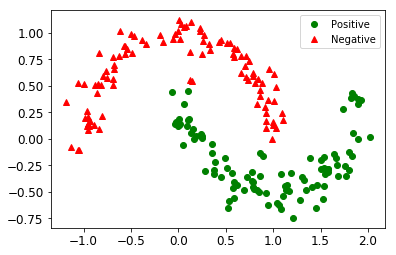

In [150]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [ ]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))